In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")




In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\MeliC\AppData\Local\Temp\ipykernel_19352\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
print(Base.classes.keys()) 

['measurement', 'station']


In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Step 7: Print the most recent date
print("Most Recent Date:", most_recent_date)

# Close the session
session.close()

Most Recent Date: 2017-08-23


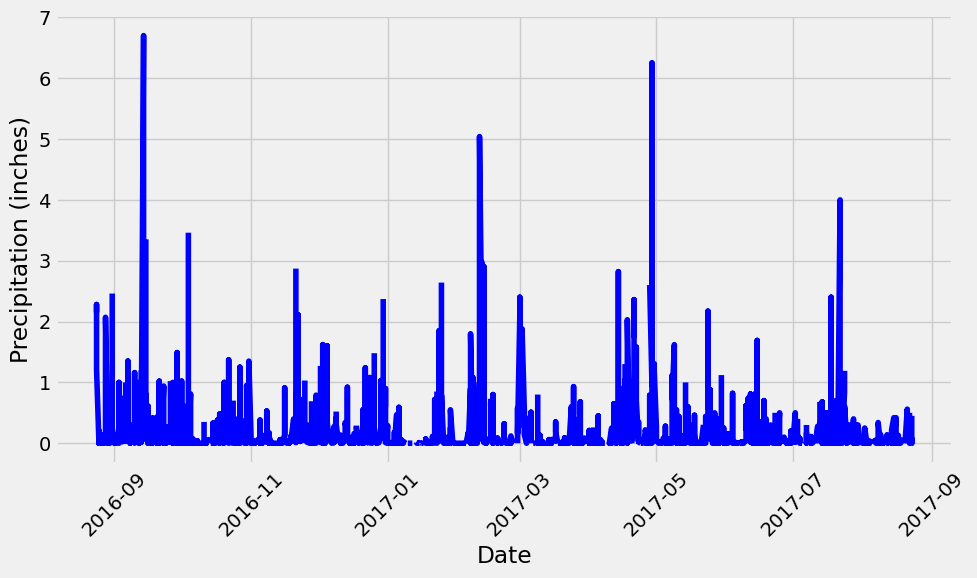

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date_obj = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.

one_year_ago = most_recent_date_obj - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date column is in datetime format
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Precipitation'], label="Precipitation", color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

session.close()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

#Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  
df = df.sort_values('Date')

precipitation_summary = df['Precipitation'].describe()


summary_df = precipitation_summary.to_frame()
print(summary_df)


session.close()

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
print(total_stations)

[(9,)]


In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

for station, count in most_active_stations:
    print(f"{station}: {count}")

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]  


temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


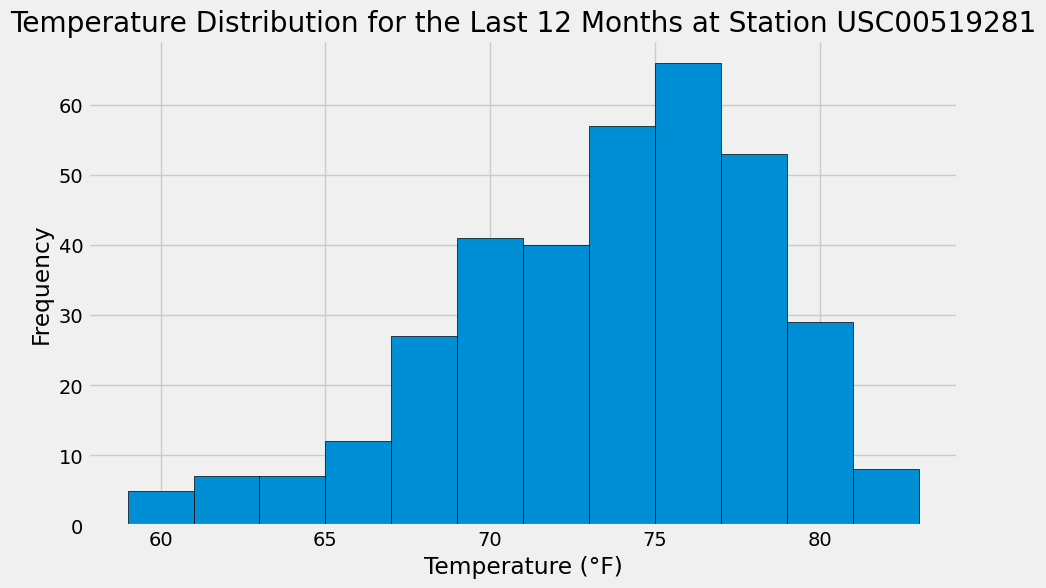

In [ ]:
# Using the most active station id
latest_date = session.query(func.max(Measurement.date)).scalar()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_months_ago = datetime.strptime(latest_date, "%Y-%m-%d") - timedelta(days=365)

last_12_months_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= twelve_months_ago.strftime("%Y-%m-%d"))
    .all()
)

temperatures = [temp[0] for temp in last_12_months_data]

# Plot the histogram of the temperature observations
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f"Temperature Distribution for the Last 12 Months at Station {most_active_station_id}")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




# Close Session

In [61]:
# Close Session
session.close()